# Librerías

In [1]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.metrics import SCORERS
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score 
from sklearn.datasets import make_classification 
import sklearn
from imblearn import under_sampling

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers  
from keras import backend as K 

import pickle

Using TensorFlow backend.


# Importar imágenes

## Funciones

In [2]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        
        if art == "Albrecht ,rer":
            lst.append("Albrecht Dürer")
        else:
            artists.append(art

        
    return images_all, artists

In [3]:
def muestra(bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Alto: {bd[num].shape[0]} px.')
    print(f'Ancho: {bd[num].shape[1]} px.')
    print(f'Profundidad: {bd[num].shape[2]} (RGB)')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

In [4]:
images, artists = open_images_names("images/**")

In [5]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Claude Monet, William Turner o Paul Klee.


Autor: Frida Kahlo
Dimensión:(484, 266, 3)
Alto: 484 px.
Ancho: 266 px.
Profundidad: 3 (RGB)


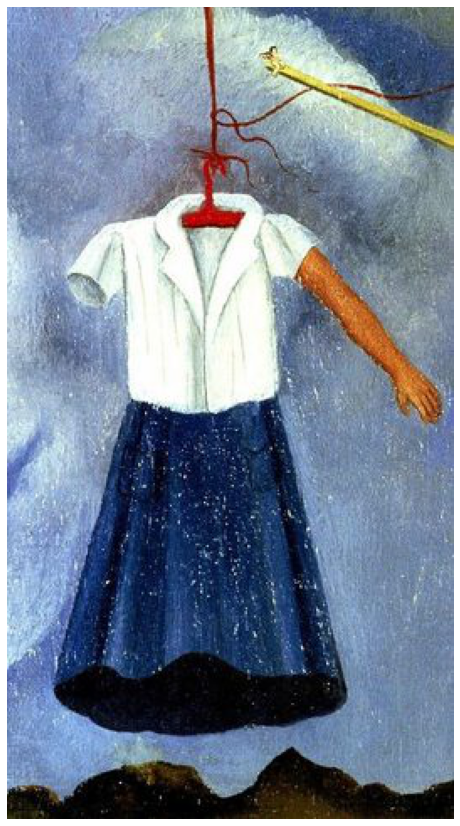

In [6]:
muestra(images)

# Corregir problemas de balanceo

## Funciones

In [7]:
def top_artists(df, y, num):
    
    """
    **************************************************************
    
    Divide la información en dos datasets diferentes usando la media
    del total de observaciones por categorías como separación.
    
    Input:
    df: dataframe a separar.
    y: variable dependiente.
    
    Output:
    *big_df: dataframe con las categorías con más observaciones.
    *small_df: dataframe con las categorías con menos observaciones.
    
    ***************************************************************
    """
    
    # Crea una lista con las etiquetas de categoría con más observaciones y otra con las que tienen menos.
    
    c = list(df['artist'].value_counts()[:num].index)
            
    # Crea dos dataframes agrupando según las categorías listadas en el paso anterior.
            
    big_df = []
    for i in c:
        big_df.extend(np.array(df[df[y] == i]))
    big_df = pd.DataFrame(big_df, columns = df.columns)

            
    return big_df

In [8]:
def visualice(df_big, df_small):
    
    """
    **************************************************************
    
    Muestra dos barplots con los artistas que se han separado.
    
    Input:
    df_big: dataframe con los artistas con más cuadros.
    df_small: dataframe con los artistas con menos cuadros.
    
    Output:
    * Barplots con ambas distribuciones
    
    ***************************************************************
    """

    print(f' El tamaño original es de {df_big.shape}. A partir de ahora trabajarás con {df_small.shape}.')
          
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(121)
    plt.title('Dataset original', fontsize=14)
    artists_plot1 = sns.countplot(df_big['artist'], color="blue")
    _=artists_plot1.set_xticklabels(artists_plot1.get_xticklabels(), rotation=65, horizontalalignment='right')
    fig.add_subplot(122)
    
    plt.title('Nueva selección', fontsize=14)
    artists_plot2 = sns.countplot(df_small['artist'], color = "blue")
    _=artists_plot2.set_xticklabels(artists_plot2.get_xticklabels(), rotation=65, horizontalalignment='right')

In [9]:
def countplot_df(df, col):
    
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], color = "blue")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

In [10]:
df = pd.DataFrame(images, columns = ['images'])

In [11]:
df['artist'] = artists

In [12]:
df.head()

,images,artist
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian


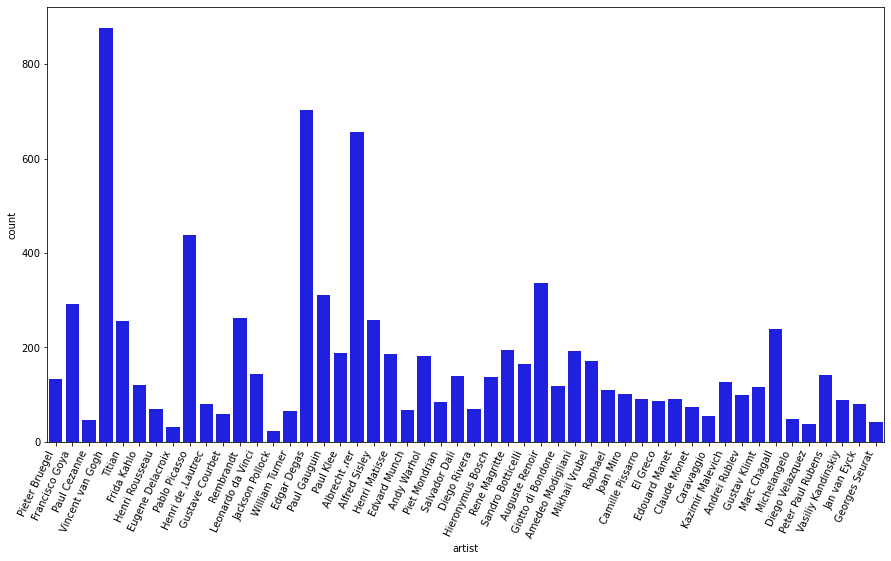

In [13]:
countplot_df(df, 'artist')

In [15]:
version1 = top_artists(df, 'artist', 10)

Dataset original vs dataset con la selección.
 El tamaño original es de (8683, 2). A partir de ahora trabajarás con (4388, 2).


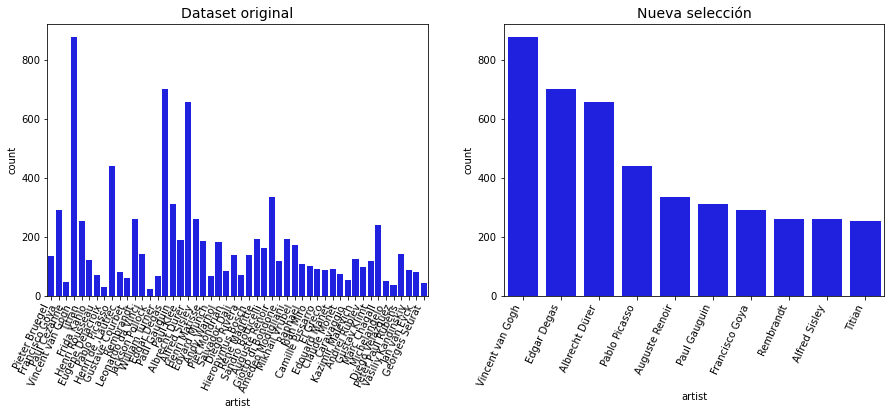

In [16]:
print("Dataset original vs dataset con la selección.")
visualice(df, version1)

# Separar train/test

In [19]:
images_v1=np.asarray(version1['images'])
artists =version1['artist']

In [20]:
num_classes = len(pd.unique(artists))

In [21]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [22]:
artists_dict

{9: 'Vincent van Gogh',
 3: 'Edgar Degas',
 0: 'Albrecht Dürer',
 5: 'Pablo Picasso',
 2: 'Auguste Renoir',
 6: 'Paul Gauguin',
 4: 'Francisco Goya',
 7: 'Rembrandt',
 1: 'Alfred Sisley',
 8: 'Titian'}

In [23]:
target_names = [artists_dict.get(i) for i in sorted(artists_dict)]

In [58]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [59]:
x_train_original, x_val_original, y_train_original, y_val_original = train_test_split(x_train_original, y_train_original, test_size=0.2, random_state=42)

In [60]:
y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
y_val = np_utils.to_categorical(y_val_original, num_classes)
y_test = np_utils.to_categorical(y_test_original, num_classes)

# Ajustar el tamaño de las imágenes

## Funciones

In [61]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imagen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [62]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

In [63]:
dim = (300, 300)

In [64]:
x_train = np.asarray(resize_data(x_train_original))

In [65]:
x_test = np.asarray(resize_data(x_test_original))

In [66]:
x_val = np.asarray(resize_data(x_val_original))

Autor: Albrecht Dürer
Dimensión original:(1229, 661, 3)
Dimensión ajustada:(300, 300, 3)
Filas originales: 1229
Filas ajustadas: 300
Columnas originales: 661
Columnas ajustadas: 300
Profundidad: 3


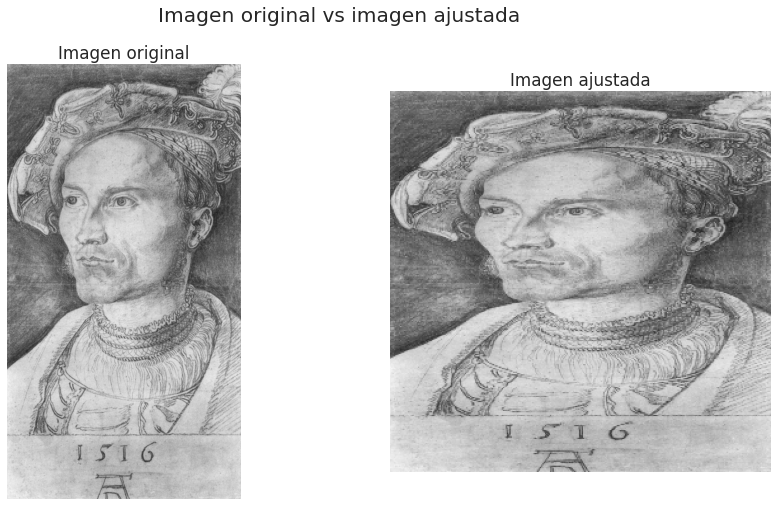

In [67]:
compara_muestras(x_train_original, x_train)

# DataAugmentation

In [68]:
#Este está creado para la visualización
train_generator_viz = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

#Este es el que pasaremos al modelo con el rescalado de valores
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        rescale = 1.0/255)

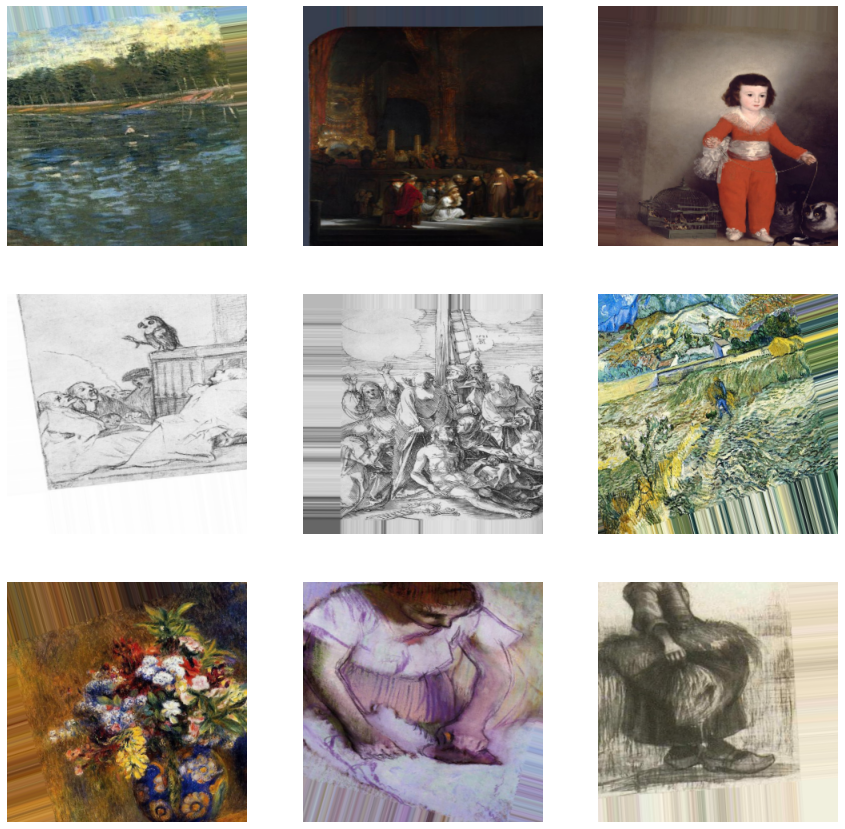

In [91]:
fig = plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator_viz.flow(x_train).next()
    image = batch[0].astype('uint8')
    plt.axis('Off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()

# Empecemos

## Funciones

In [92]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, cmap = "Blues", vmax = 50,annot_kws={"size": 12}, xticklabels=target_names, yticklabels=target_names)  
    plt.show() 

In [93]:
def plot_train_vs_val (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [94]:
def test_img(model_predicted):
    
    """
    **************************************************************
    
    Devuelve una imagen con el resultado del modelo de predicción
    indicado.
    
    Input:
    -model_predicted: resultados del modelo con el test.
    
    Output:
    -Imagen con la predicción.
    
    
    ***************************************************************
    """
    
    
    #Genera la elección aleatoria de la imagen
    num = random.randrange(len(y_test))
    
    #Imprime la imagenx
    plt.imshow(cv2.cvtColor(x_test_original[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    #Busca en el diccionario para devolver el nombre del artista y no la etiqueta
    real= artists_dict.get(np.argmax(y_test[num]))
    predicted= artists_dict.get(model_predicted[num])
    
    #Muestra la etiqueta real y la predicha.
    print(f'Artista real      :   {real}')  
    print(f'Artista predicho  :   {predicted}') 

In [95]:
def guardar(model, model_name):
    
    """
    **************************************************************
    
    Guarda el modelo en formato h5 y su histórico en txt.
    
    Input:
    -model: modelo a guardar
    
    Output:
    -Imagen con la predicción
    
    
    ***************************************************************
    """
    #Modelo
    model.save(model_name+'.h5')
    #Histórico
    with open(model_name + '.txt', 'wb') as file_pi:  
        pickle.dump(model.history, file_pi)

In [96]:
K.set_image_data_format('channels_last')  

In [97]:
K.set_learning_phase(1) 

## Hiperparamétros

In [98]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks = [early_stop, reduce_lr] 

In [99]:
epochs = 100
batch_size = 32

# IncepcionResNetV2 con ImageNet

## Creamos la red

In [100]:
def build_IncepcionImagenet_model(layers):
    imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)
    x = imagenet_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x) 
    imagenet_model = Model(input=imagenet_model.input, output=predictions)
    for layer in imagenet_model.layers[:layers]:
        layer.trainable = False
    
    return imagenet_model

In [101]:
imagenet_model = build_IncepcionImagenet_model(700)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [102]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

## Entrenamos el modelo

In [104]:
imagenet = imagenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
87/87 [==============================] - 60s 694ms/step - loss: 0.9713 - acc: 0.6754 - mse: 0.0440 - val_loss: 0.6296 - val_acc: 0.8048 - val_mse: 0.0292
Epoch 2/100
87/87 [==============================] - 56s 648ms/step - loss: 0.4882 - acc: 0.8343 - mse: 0.0238 - val_loss: 0.6104 - val_acc: 0.7991 - val_mse: 0.0276
Epoch 3/100
87/87 [==============================] - 56s 646ms/step - loss: 0.3356 - acc: 0.8847 - mse: 0.0166 - val_loss: 0.5003 - val_acc: 0.8405 - val_mse: 0.0231
Epoch 4/100
87/87 [==============================] - 56s 646ms/step - loss: 0.2807 - acc: 0.9067 - mse: 0.0142 - val_loss: 0.4829 - val_acc: 0.8618 - val_mse: 0.0209
Epoch 5/100
87/87 [==============================] - 57s 651ms/step - loss: 0.2228 - acc: 0.9254 - mse: 0.0111 - val_loss: 0.5778 - val_acc: 0.8291 - val_mse: 0.0253
Epoch 6/100
87/87 [==============================] - 56s 646ms/step - loss: 0.1997 - acc: 0.9316 - mse: 0.0100 - val_loss: 0.5346 - val_acc: 0.8618 - val_mse: 0.0218
Epoc

## Evaluamos el modelo

In [112]:
imagenet_evaluation = imagenet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
imagenet_evaluation

88/88 [==============================] - 46s 524ms/step


[0.011968757025897503, 0.9889600872993469, 0.0018183342181146145]

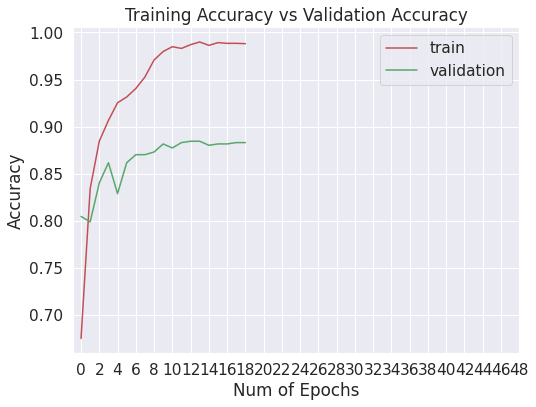

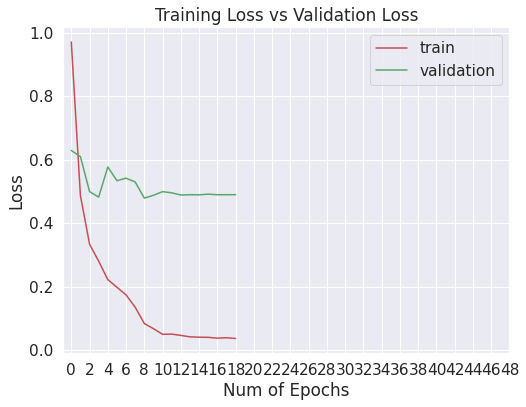

In [113]:
plot_train_vs_val(imagenet)

## Predicción del modelo

In [114]:
imagenet_pred = imagenet_model.predict(x_test, batch_size=batch_size, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1) 

878/878 [==============================] - 10s 11ms/step


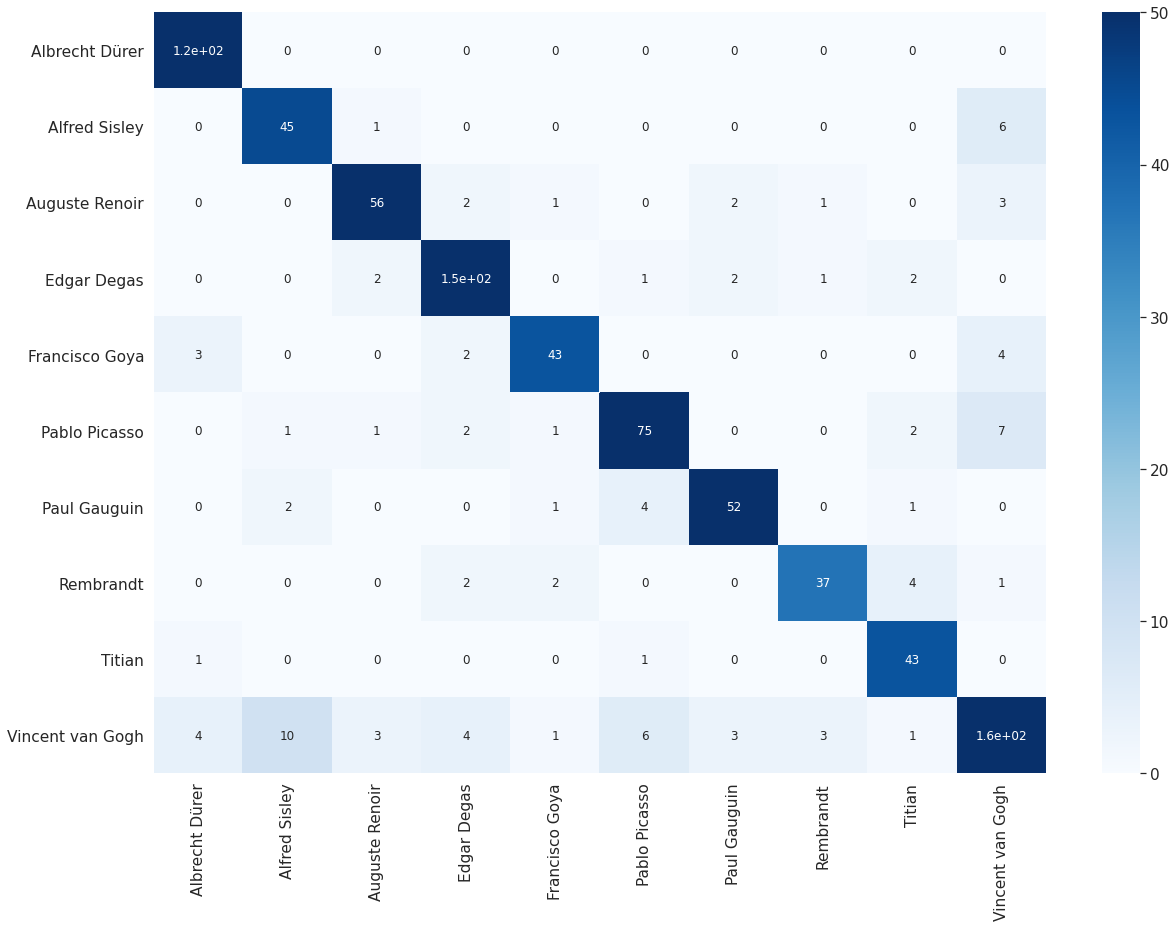

In [115]:
conf_matrix (num_classes, imagenet_predicted)

In [116]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted, target_names=target_names)  
print(imagenet_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.94      1.00      0.97       122
   Alfred Sisley       0.78      0.87      0.82        52
  Auguste Renoir       0.89      0.86      0.88        65
     Edgar Degas       0.92      0.95      0.94       155
  Francisco Goya       0.88      0.83      0.85        52
   Pablo Picasso       0.86      0.84      0.85        89
    Paul Gauguin       0.88      0.87      0.87        60
       Rembrandt       0.88      0.80      0.84        46
          Titian       0.81      0.96      0.88        45
Vincent van Gogh       0.88      0.82      0.85       192

        accuracy                           0.88       878
       macro avg       0.87      0.88      0.87       878
    weighted avg       0.89      0.88      0.88       878



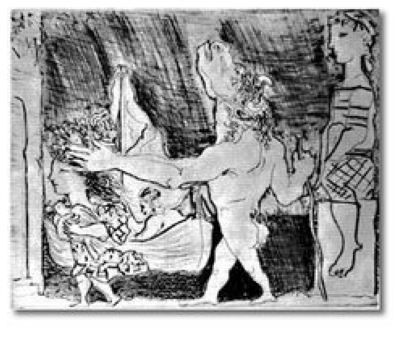

Artista real      :   Pablo Picasso
Artista predicho  :   Vincent van Gogh


In [117]:
test_img(imagenet_predicted)

## Conclusiones

Aumentando la calidad de las imagenes y trabajando con 300px en vez de 100px hemos conseguido aumentar 11 puntos del *accuracy*. Ha tardado cerca 20 minutos en ejecutarse.

## Guardar los resultados

In [111]:
guardar(imagenet_model, "imagenet_model")